In [1]:
# ==========================================
# 1. SETUP & IMPORTS
# ==========================================
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import pickle
import re
import numpy as np
from PIL import Image

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cpu


In [2]:
# Load vocab
with open('/kaggle/input/training-result/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

# Build inverse vocab
inv_vocab = {idx: word for word, idx in vocab.items()}

pad_token_id = vocab["<pad>"]
bos_token_id = vocab["<bos>"]
eos_token_id = vocab["<eos>"]
unk_token_id = vocab["<unk>"]

vocab_size = len(vocab)
print("Vocab size:", vocab_size)


Vocab size: 5156


In [3]:
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [4]:
class ImgToCaptionModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=300, max_seq_len=50, pad_token_id=0):
        super().__init__()

        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.max_seq_len = max_seq_len
        self.pad_token_id = pad_token_id

        self.row_embed = nn.Parameter(torch.randn(8, embed_dim) * 0.02)
        self.col_embed = nn.Parameter(torch.randn(8, embed_dim) * 0.02)

        resnet = models.resnet50(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])

        self.prep = nn.Sequential(
            nn.Linear(2048, 300),
            nn.LayerNorm(300),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_token_id)

        self.pos_encoding = nn.Parameter(
            torch.randn(max_seq_len, embed_dim) * 0.02
        )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=300,
            nhead=6,
            dim_feedforward=1024,
            batch_first=True
        )

        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=3
        )

        self.fc_out = nn.Linear(embed_dim, vocab_size)

    def forward(self, images, captions):
        img_features = self.cnn(images)
        img_features = img_features.flatten(2).transpose(1, 2)
        img_features = self.prep(img_features)

        pos = self.row_embed[:, None, :] + self.col_embed[None, :, :]
        pos = pos.reshape(64, -1)
        img_features = img_features + pos.unsqueeze(0)

        seq_len = captions.size(1)
        caption_embeds = self.embedding(captions)
        caption_embeds = caption_embeds + self.pos_encoding[:seq_len]

        tgt_mask = torch.triu(
            torch.ones(seq_len, seq_len, device=captions.device, dtype=torch.bool),
            diagonal=1
        )

        output = self.transformer_decoder(
            tgt=caption_embeds,
            memory=img_features,
            tgt_mask=tgt_mask
        )

        return self.fc_out(output)


In [5]:
model = ImgToCaptionModel(
    vocab_size=len(vocab),
    embed_dim=300,
    max_seq_len=50,
    pad_token_id=pad_token_id
).to(device)

model.load_state_dict(
    torch.load('/kaggle/input/training-result/image_caption_model_last.pth', map_location=device)
)

model.eval()
print("✅ Model loaded")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 146MB/s]


✅ Model loaded


In [6]:
@torch.no_grad()
def generate_caption(image, max_len=30):
    image = image.unsqueeze(0).to(device)

    caption = torch.tensor([[bos_token_id]], device=device)

    for _ in range(max_len):
        outputs = model(image, caption)
        next_token_logits = outputs[:, -1, :]
        next_token = next_token_logits.argmax(dim=-1)

        caption = torch.cat([caption, next_token.unsqueeze(1)], dim=1)

        if next_token.item() == eos_token_id:
            break

    caption_ids = caption.squeeze(0).tolist()
    words = [inv_vocab.get(idx, "<unk>") for idx in caption_ids]

    return " ".join(words[1:-1])  # remove <bos> and <eos>


Found 8 images


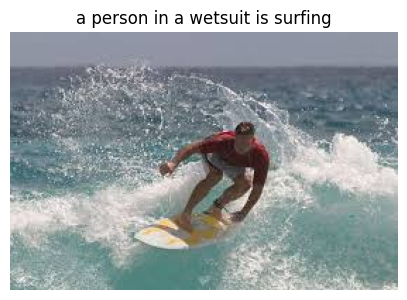

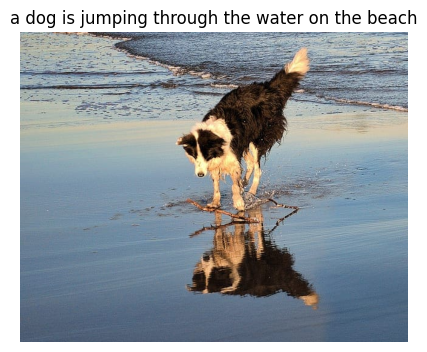

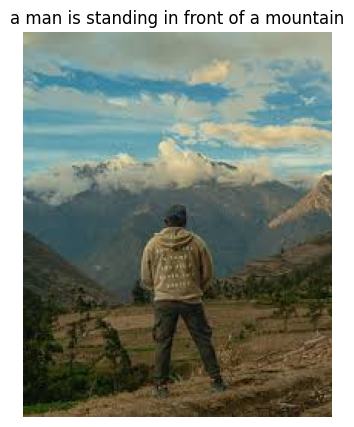

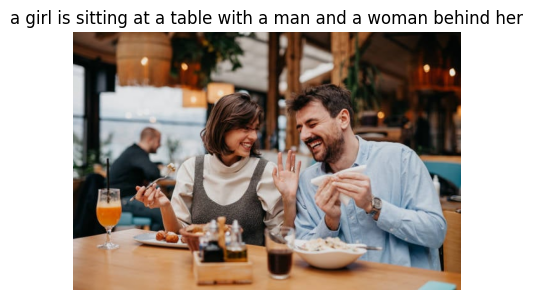

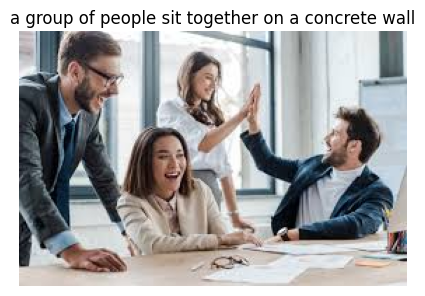

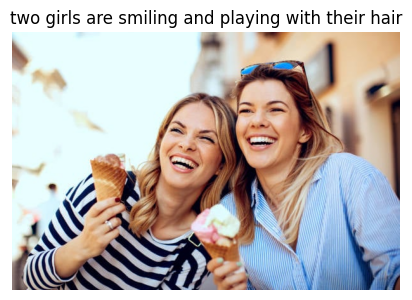

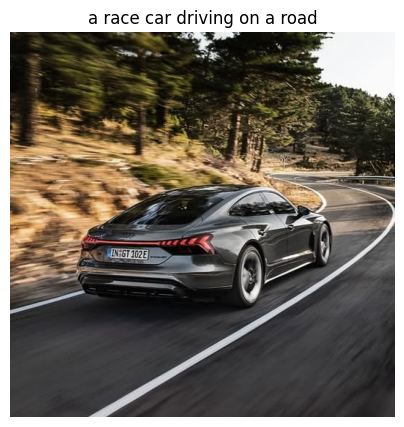

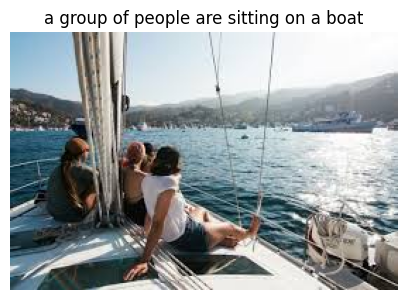

In [7]:
import os
import matplotlib.pyplot as plt

test_image_dir = "/kaggle/input/test-images"

image_files = sorted([
    f for f in os.listdir(test_image_dir)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
])

print(f"Found {len(image_files)} images")

for img_name in image_files:
    img_path = os.path.join(test_image_dir, img_name)

    # Load image (for model)
    image_pil = Image.open(img_path).convert("RGB")
    image_tensor = image_transform(image_pil)

    # Generate caption
    caption = generate_caption(image_tensor)

    # Show image
    plt.figure(figsize=(5, 5))
    plt.imshow(image_pil)
    plt.axis("off")
    plt.title(caption, fontsize=12)
    plt.show()
